In [ ]:
from openai import OpenAI

client = OpenAI()

response = client.responses.create(
    model="gpt-4.1",
    input="Say hello in exactly three words.",
    include=["message.output_text.logprobs"],  # ask for logprobs
    top_logprobs=5,                            # up to 5 most likely tokens per position
)

# The main text is still easy to get:
print("Text:", response.output[0].content[0].text)

# And you can inspect token-level logprobs:
msg = response.output[0]
text_item = next(c for c in msg.content if c.type == "output_text")

for i, token_info in enumerate(text_item.logprobs):
    # exact field names may vary slightly by SDK version, but conceptually:
    # token_info.token       -> the generated token
    # token_info.logprob     -> log p(token)
    # token_info.top_logprobs -> list of { token, logprob } for alternatives
    print(f"{i}: {token_info.token!r}  logprob={token_info.logprob}")
    for alt in token_info.top_logprobs:
        print("   alt:", repr(alt.token), alt.logprob)




In [ ]:
from openai import OpenAI
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv

load_dotenv()
client = OpenAI()

sentence = " "  # prompt

resp = client.responses.create(
    model="gpt-4.1-mini",
    input=sentence,
    temperature=0,
    max_output_tokens=16,

    # ✅ Responses API way to get logprobs:
    top_logprobs=20,  # up to 20 per token
    include=["message.output_text.logprobs"],
)

# Grab the first output_text content block
content0 = resp.output[0].content[0]

# `content0.logprobs` is a list: one entry per generated token
first_token_logprobs = content0.logprobs[0]

# Top alternatives for that first generated token
top = first_token_logprobs.top_logprobs  # list of objects with .token and .logprob

logprobs = {lp.token: lp.logprob for lp in top}
print(f"Number of tokens received: {len(logprobs)}")

probs = {tok: float(np.exp(lp)) for tok, lp in logprobs.items()}

# Normalize (top_n doesn't necessarily sum to 1)
total = sum(probs.values())
probs = {tok: p / total for tok, p in probs.items()}

sorted_items = sorted(probs.items(), key=lambda x: x[1], reverse=True)

print("\nTop 10 tokens with their probabilities:")
for tok, p in sorted_items[:10]:
    print(f"'{tok}': {p:.3%}")

tokens, probabilities = zip(*sorted_items)

plt.figure(figsize=(15, 10))
plt.barh(range(len(tokens)), probabilities)
plt.yticks(range(len(tokens)), tokens)
plt.title(f"Distribution of Next Token Probabilities (Total tokens: {len(tokens)})")
plt.xlabel("Probability")
plt.ylabel("Token")

for i, p in enumerate(probabilities[:10]):
    plt.text(p, i, f" {p:.1%}", va="center")

plt.tight_layout()
plt.show()


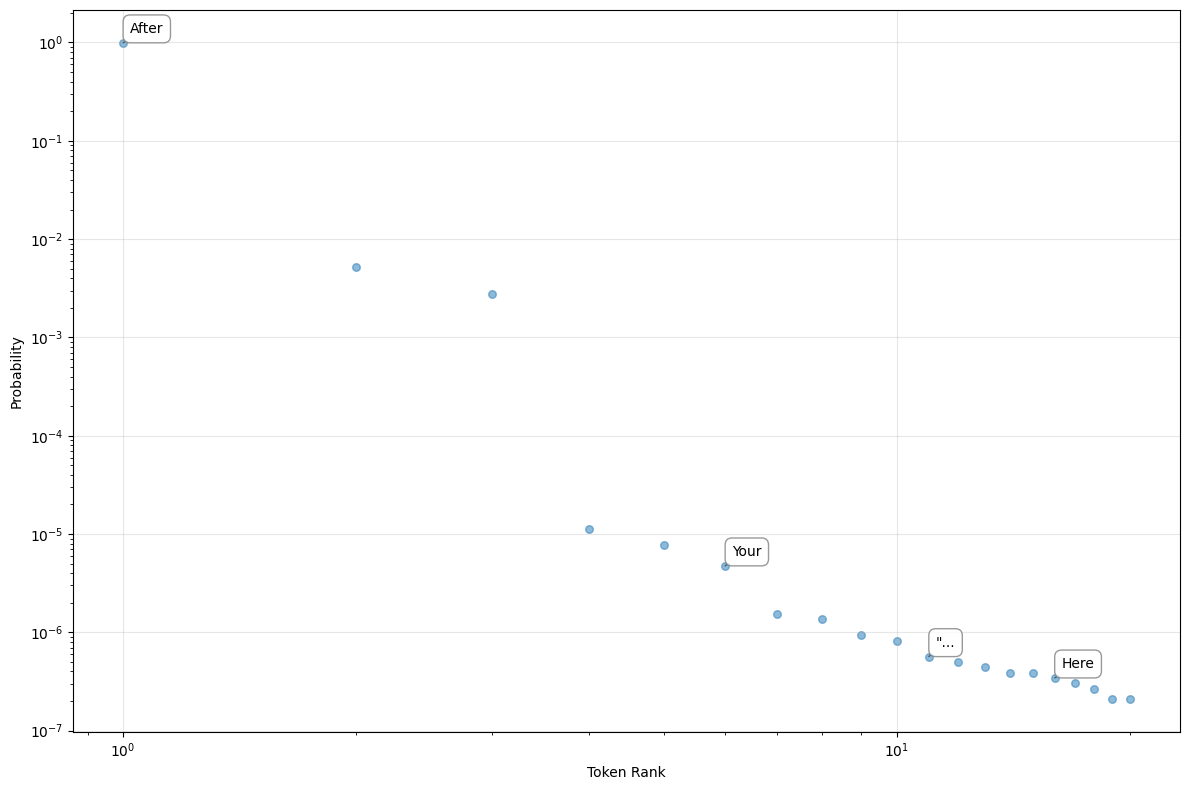


Top 10 tokens with their probabilities:
'After': 99.197%
'to': 0.521%
'"': 0.279%
'“': 0.001%
'after': 0.001%
'Your': 0.000%
'To': 0.000%
'success': 0.000%
'Success': 0.000%
'…': 0.000%


In [3]:
from openai import OpenAI
import matplotlib.pyplot as plt
import numpy as np
from dotenv import load_dotenv

load_dotenv()
client = OpenAI()

sentence = "After years of hard work, your effort will take you"

resp = client.responses.create(
    model="gpt-4.1-mini",
    input=sentence,
    temperature=0,
    max_output_tokens=16,

    # ✅ Correct way for Responses API:
    # ask for top-k token alternatives with logprobs
    top_logprobs=20,  # API allows 0–20; 50 would be invalid
    include=["message.output_text.logprobs"],
)

# First assistant message's first content block (output_text)
content0 = resp.output[0].content[0]

# `content0.logprobs` is a list: one entry per generated token
first_token_logprobs = content0.logprobs[0]

# Top-k alternatives for that first token
top = first_token_logprobs.top_logprobs  # list of objects with .token and .logprob

logprobs = {lp.token: lp.logprob for lp in top}
probs = {tok: float(np.exp(lp)) for tok, lp in logprobs.items()}

# Sort by probability, descending
sorted_items = sorted(probs.items(), key=lambda x: x[1], reverse=True)
tokens, probabilities = zip(*sorted_items)

plt.figure(figsize=(12, 8))
x_positions = np.arange(1, len(tokens) + 1)
plt.scatter(x_positions, probabilities, alpha=0.5, s=30)

plt.xscale("log")
plt.yscale("log")

plt.grid(True, alpha=0.3)
plt.xlabel("Token Rank")
plt.ylabel("Probability")

for i, (tok, p) in enumerate(zip(tokens, probabilities)):
    if p > 0.01 or i % 5 == 0:
        plt.annotate(
            tok,
            xy=(x_positions[i], p),
            xytext=(5, 5),
            textcoords="offset points",
            ha="left",
            va="bottom",
            bbox=dict(boxstyle="round,pad=0.5", fc="white", ec="gray", alpha=0.8),
            arrowprops=dict(arrowstyle="-", alpha=0.5),
        )

plt.tight_layout()
plt.show()

print("\nTop 10 tokens with their probabilities:")
for tok, p in list(zip(tokens, probabilities))[:10]:
    print(f"'{tok}': {p:.3%}")


In [5]:
print("Text:", resp.output[0].content[0].text)

Text: After years of hard work, your effort will take you to success, fulfillment,
